# Data Source
* [Famine](https://web.archive.org/web/20170802193952/http://fletcher.tufts.edu/World-Peace-Foundation/Program/Research/Mass-Atrocities-Research-Program/Mass-Famine#Dataset)

I came across this data from the [World in Data Famine Post](https://ourworldindata.org/famines). 

# Data Preparation

In [162]:
# Get all necessary packages
import pandas as pd
import os
import scipy.stats as stats
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import numpy as np

In [163]:
# Read in and check file
famine = pd.read_csv("data" + os.sep + "famine" + os.sep + "famine.csv", sep = ",")
#famine.head()

In [164]:
# Calculate duration 
# Add one to avoid duration of 0
famine["Duration"] = (famine["End Year"]+1) - famine["Start Year"]
#famine.head()

I decided to not work with the total death count of the famines, but instead calculate how many people died per year the famine persisted. This makes them more easily comparable. 

In [165]:
# Calculate death per year
famine["Death per Year"] = famine["Mean Death"] / famine["Duration"]
#famine.head()

Text(0.5, 0, 'Death per year')

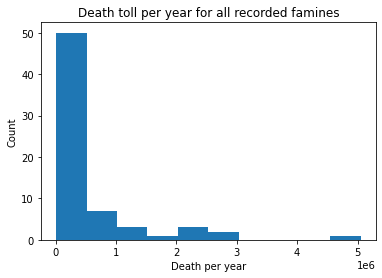

In [166]:
# Plot death per year
ax = famine["Death per Year"].sort_values(ascending=False).plot(kind="hist", bins= 10)
ax.set_title("Death toll per year for all recorded famines")
ax.set_ylabel("Count")
ax.set_xlabel("Death per year")

# Prepare for histogram fitting

I first tried to do this via fitting to a histogram, as Morgan proposed. However, I am not so sure if this is a good way to do it. Making a histogram means binning the data and if possible you should always do your analysis on unbinned data. Also, the break is quite hard if we use it that way, which results in worse fits. 

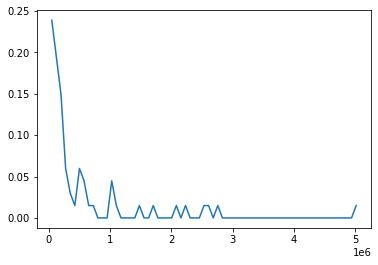

In [167]:
# Bin the data
density, death_per_year = np.histogram(famine["Death per Year"], bins = len(famine.index), density=True)
# adjust the denisty to the bin width (https://stackoverflow.com/questions/21532667/numpy-histogram-cumulative-density-does-not-sum-to-1)
density = density*np.diff(death_per_year)
# calculate the bin means
death_per_year = np.array([0.5 * (death_per_year[i] + death_per_year[i+1]) for i in range(len(death_per_year)-1)])
# plot
plt.plot(death_per_year, density)

# Histogram fit to Power Law
As the histogram data is so rough, we can get a fit, but not a great one. 

In [168]:
# Fit data to power law
def powerlaw(x,exponent):
    return (x**exponent)/np.min(x)**exponent
params, covar = curve_fit(powerlaw, death_per_year, density)
params

array([-1.57879647])

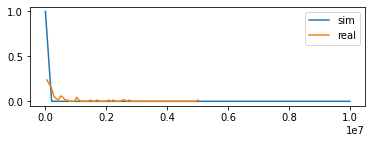

In [169]:
# Plot the power law
x_sim = np.linspace(1,10000000)
y_sim = powerlaw(x_sim, params[0])
fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)
ax.plot(x_sim, y_sim,label="sim")
ax.plot(death_per_year, density, label="real")
ax.legend()
#ax.set_yscale("log")
#ax.set_xscale("log")

# Histogram fit to lognormal
Lognormal is even worse, so I would recommend sticking to the powerlaw. 

In [170]:
# Fit data to lognormal
def lognormal(x,upsilon,epsilon):
    numerator=np.exp(-np.power((np.log(x)-upsilon),2)/(2*epsilon**2))
    denominator=x*np.sqrt(2*np.pi*epsilon**2)
    return numerator/denominator
params, covar = curve_fit(lognormal, death_per_year, density)
params

array([1., 1.])

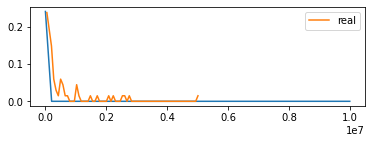

In [171]:
# Plot the lognormal
x_sim = np.linspace(1,10000000)
y_sim = lognormal(x_sim, params[0], params[1])
fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)
ax.plot(x_sim, y_sim)
ax.plot(death_per_year, density, label="real")
ax.legend()
#ax.set_xscale("log")
#ax.set_yscale("log")

# Cumulative distribution fitting with power law

In [172]:
# Sort for further calculations with cumsum
famine=famine.sort_values("Death per Year",ascending=False)

Text(0.5, 1.0, 'Probability of reaching this much death per year per year')

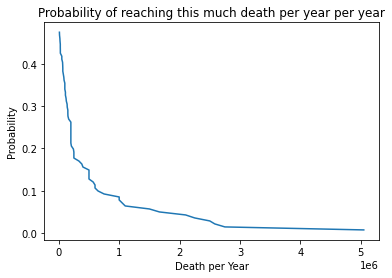

In [173]:
# Calculate the probability in a year with a given famine
# Does it make more sense to take the whole timeline with 141 or just the years with famine?
years_with_famine = 141
famine["time"] = 1/years_with_famine
famine["cs_time"] = np.cumsum(famine["time"])
# Plot
fig = plt.Figure()
plt.plot(famine["Death per Year"], famine["cs_time"])
ax = plt.gca()
ax.set_xlabel("Death per Year")
ax.set_ylabel("Probability")
ax.set_title("Probability of reaching this much death per year per year")

In [174]:


# Define function for calculating a power law
powerlaw = lambda x, amp, index: amp * (x**index)
# Provide values for the parameters to avoid them becoming to negative?
params, covar = curve_fit(func_powerlaw, famine["Death per Year"], famine["cs_time"], maxfev=100000)
params

array([ 1.48601236e-04, -6.45529736e+02,  6.46948543e+02])

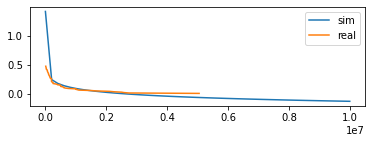

In [175]:
# Plot the power law
x_sim = np.linspace(1,10000000)
y_sim = func_powerlaw(x_sim, params[0], params[1], params[2])
fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)
ax.plot(x_sim, y_sim, label="sim")
ax.plot(famine["Death per Year"], famine["cs_time"], label="real")
#ax.set_ylim([0,1])
ax.legend()
#ax.set_xscale("log")
#ax.set_yscale("log")

In [176]:
# Probability of death by famine
amount_dead = np.array([1,10,100,1000,10000,100000,1000000,10000000,100000000,1000000000])
probs = func_powerlaw(amount_dead, params[0], params[1], params[2])
for i in range(len(amount_dead)):
    print("Dead: " + (str(amount_dead[i])))
    print("Prob of this many dead: " + str(probs[i]))

Dead: 1
Prob of this many dead: 1.4188065438190733
Dead: 10
Prob of this many dead: 1.1978897829220614
Dead: 100
Prob of this many dead: 0.9768974186678179
Dead: 1000
Prob of this many dead: 0.7558294251829238
Dead: 10000
Prob of this many dead: 0.5346857765852064
Dead: 100000
Prob of this many dead: 0.31346644698351156
Dead: 1000000
Prob of this many dead: 0.09217141047781752
Dead: 10000000
Prob of this many dead: -0.12919935884076494
Dead: 100000000
Prob of this many dead: -0.3506458868896516
Dead: 1000000000
Prob of this many dead: -0.5721681995956942


# Fitting cumulative distribution in loglog space
Morgan recommended that we could also try fitting this in loglog space. This kinda works, but I am unsure what to make of the results. 

In [177]:
# Transform data in loglog space
log_death_rate = np.log(famine["Death per Year"])
log_cs_time = np.log(famine["cs_time"])

In [178]:

# Define function for calculating a power law
powerlaw = lambda x, amp, index: amp * (x**index)
# Provide values for the parameters to avoid them becoming to negative?
params, covar = curve_fit(func_powerlaw, log_death_rate, log_cs_time, maxfev=100000)
params

array([-4.29396766e-04,  1.64038788e+04, -1.63879762e+04])

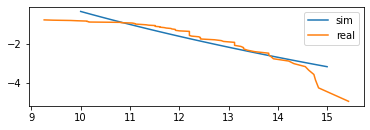

In [181]:
# Plot the power law
x_sim = np.linspace(10,15)
y_sim = func_powerlaw(x_sim, params[0], params[1], params[2])
fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)
ax.plot(x_sim, y_sim, label="sim")
ax.plot(log_death_rate, log_cs_time, label="real")
ax.legend()
#ax.set_ylim([0,1])
#ax.set_xscale("log")
